<a href="https://colab.research.google.com/github/aniketmishr/custom-object-detection/blob/main/object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'car-detection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1567703%2F2580983%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240907%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240907T164800Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc5e33ddf46ae311a013ab97b64dbec523b682bb2bf50cade7199aad4aba3a1b7d10cb78addb76ee41eb67c404b3582213ae62afc53905866ac219b15b58d00f9c3f049c309bf94546a48ae904cd5fb169677905bf6873e6853add5eac007ef3fcb053e31c010a9e5dc0308e9438ba59234a9a1c05125a3f74ceb4e9b72ca5d9ecc0d9d475858dc7f30207089f533470fc85caed2bc74eefa76252e281da0941a58d29942d2fef4d9833f8e3535cd0e8ee87b9385f722c4726d4c6cd79f00ec2660378b92bf898390f9c6b336a3314b419bf85bcc90097e57aea61951f13ca8ee026dd0b5a9139d48761ce4507e926ccec0600e1a28f82d39c22cb6f0721bf3e6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 929394530 bytes downloaded
Downloaded and uncompressed: car-detection-dataset
Data source import complete.


In [2]:
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import cv2
import numpy as np
import os, warnings
from matplotlib import pyplot as plt
import matplotlib.patches as patches
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Preparing and Pre Processing Data

In [3]:
def parse(path):
    files = []
    for dirent in tqdm(list(os.scandir(Path(path) / 'labels'))):
        label_path = dirent.path
        with open(label_path) as f:
            data = [float(x) for x in f.read().strip().split(' ')]
        im_path = str(Path(path) / 'images' / Path(dirent.name).stem) + '.jpg'
        im = Image.open(im_path)
        data = data + list(im.size)
        data[0] = im_path
        files.append(data)
    return files

ds1 = parse('/kaggle/input/car-detection-dataset/car_dataset-master/train')
ds2 = parse('/kaggle/input/car-detection-dataset/car_dataset-master/test')
ds3 = parse('/kaggle/input/car-detection-dataset/car_dataset-master/valid')

ds1[:2]

100%|██████████| 1618/1618 [00:00<00:00, 5466.95it/s]


[['/kaggle/input/car-detection-dataset/car_dataset-master/train/images/013751.jpg',
  0.503437,
  0.532222,
  0.731875,
  0.84,
  1600,
  900],
 ['/kaggle/input/car-detection-dataset/car_dataset-master/train/images/015007.jpg',
  0.544922,
  0.552734,
  0.753906,
  0.83724,
  1024,
  768]]

In [4]:
train_df = pd.DataFrame(ds1, columns=['path', 'center_x', 'center_y', 'w', 'h', 'w_px', 'h_px'])
valid_df = pd.DataFrame(ds2, columns=['path', 'center_x', 'center_y', 'w', 'h', 'w_px', 'h_px'])
test_df = pd.DataFrame(ds3, columns=['path', 'center_x', 'center_y', 'w', 'h', 'w_px', 'h_px'])

In [5]:

def load_and_preprocess_image(path, target_size=(224, 224)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]
    return image

def resize_image_and_box(image, box, target_size=(224, 224)):
    # Get original image shape
    original_shape = tf.shape(image)
    original_height = tf.cast(original_shape[0], tf.float32)
    original_width = tf.cast(original_shape[1], tf.float32)

    # Resize the image
    image = tf.image.resize(image, target_size)

    # Calculate scale factors
    scale_x = target_size[1] / original_width
    scale_y = target_size[0] / original_height

    # Unnormalize bounding box coordinates to original image size
    norm_center_x, norm_center_y, norm_width, norm_height = tf.unstack(box)

    # Convert normalized coordinates to pixel coordinates in the original image
    center_x = norm_center_x * original_width
    center_y = norm_center_y * original_height
    width = norm_width * original_width
    height = norm_height * original_height

    # Resize bounding box coordinates based on scaling factors
    resized_center_x = center_x * scale_x
    resized_center_y = center_y * scale_y
    resized_width = width * scale_x
    resized_height = height * scale_y

    # Normalize bounding box coordinates to resized image size
    resized_norm_center_x = resized_center_x / target_size[1]
    resized_norm_center_y = resized_center_y / target_size[0]
    resized_norm_width = resized_width / target_size[1]
    resized_norm_height = resized_height / target_size[0]

    # Stack resized normalized box coordinates
    resized_box = tf.stack([resized_norm_center_x, resized_norm_center_y, resized_norm_width, resized_norm_height])

    return image, resized_box


def parse_data(row, target_size=(224, 224)):
    image = load_and_preprocess_image(row['path'], target_size)
    box = tf.convert_to_tensor([row['center_x'], row['center_y'], row['w'], row['h']], dtype=tf.float32)
    image, box = resize_image_and_box(image, box, target_size)
    return image, box

def create_dataset(df, batch_size=32, target_size=(224, 224), shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(dict(df))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.map(lambda row: parse_data(row, target_size), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


def visualize(image, box):
    image_h, image_w, channel = image.shape
    box = [box[0]*image_w, box[1]*image_h, box[2]*image_w, box[3]*image_h]
    center_x, center_y, box_width, box_height = box
    top_left_x = center_x - box_width / 2
    top_left_y = center_y - box_height / 2
    bottom_right_x = center_x + box_width / 2
    bottom_right_y = center_y + box_height / 2

    plt.imshow(image, cmap='gray')
    plt.gca().add_patch(plt.Rectangle((top_left_x, top_left_y), box_width, box_height,
                                      edgecolor='red', facecolor='none', lw=2))
    plt.show()

def visualize_batch(images, labels, batch_size, target_size=(224, 224)):
    # Convert images and labels to numpy arrays for visualization
    images = images.numpy()
    labels = labels.numpy()

    # Number of images in the batch
    num_images = images.shape[0]

    # Set up the plot grid
    num_cols = 4  # Number of columns in the grid
    num_rows = int(np.ceil(num_images / num_cols))  # Number of rows in the grid

    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Plot image
        image = images[i]
        plt.imshow(image.squeeze(), cmap='gray')

        # Plot bounding box if available
        box = labels[i]
        center_x, center_y, width, height = box
        center_x *= target_size[1]
        center_y *= target_size[0]
        width *= target_size[1]
        height *= target_size[0]

        # Calculate bounding box coordinates
        x_min = int(center_x - width / 2)
        x_max = int(center_x + width / 2)
        y_min = int(center_y - height / 2)
        y_max = int(center_y + height / 2)

        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          fill=False, edgecolor='red', linewidth=2))

        plt.axis('off')
        plt.title(f'Image {i + 1}')

    plt.tight_layout()
    plt.show()


In [6]:

batch_size = 32
target_size = (224, 224)

train_ds = create_dataset(train_df, batch_size=batch_size, target_size=target_size)
valid_ds = create_dataset(valid_df, batch_size=batch_size, target_size=target_size)
test_ds = create_dataset(test_df, batch_size=batch_size, target_size=target_size)

# Visualizing Single Image of a batch

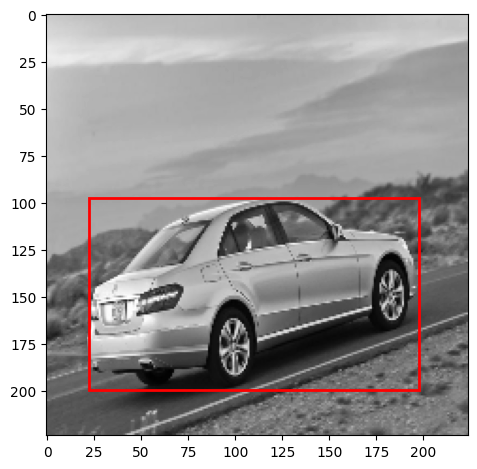

In [7]:
x=0
for images, labels in test_ds.take(1):
    if x==0:
        visualize(images[30],labels[30])
        x+=1

# Visualizing all the images present in the training batch

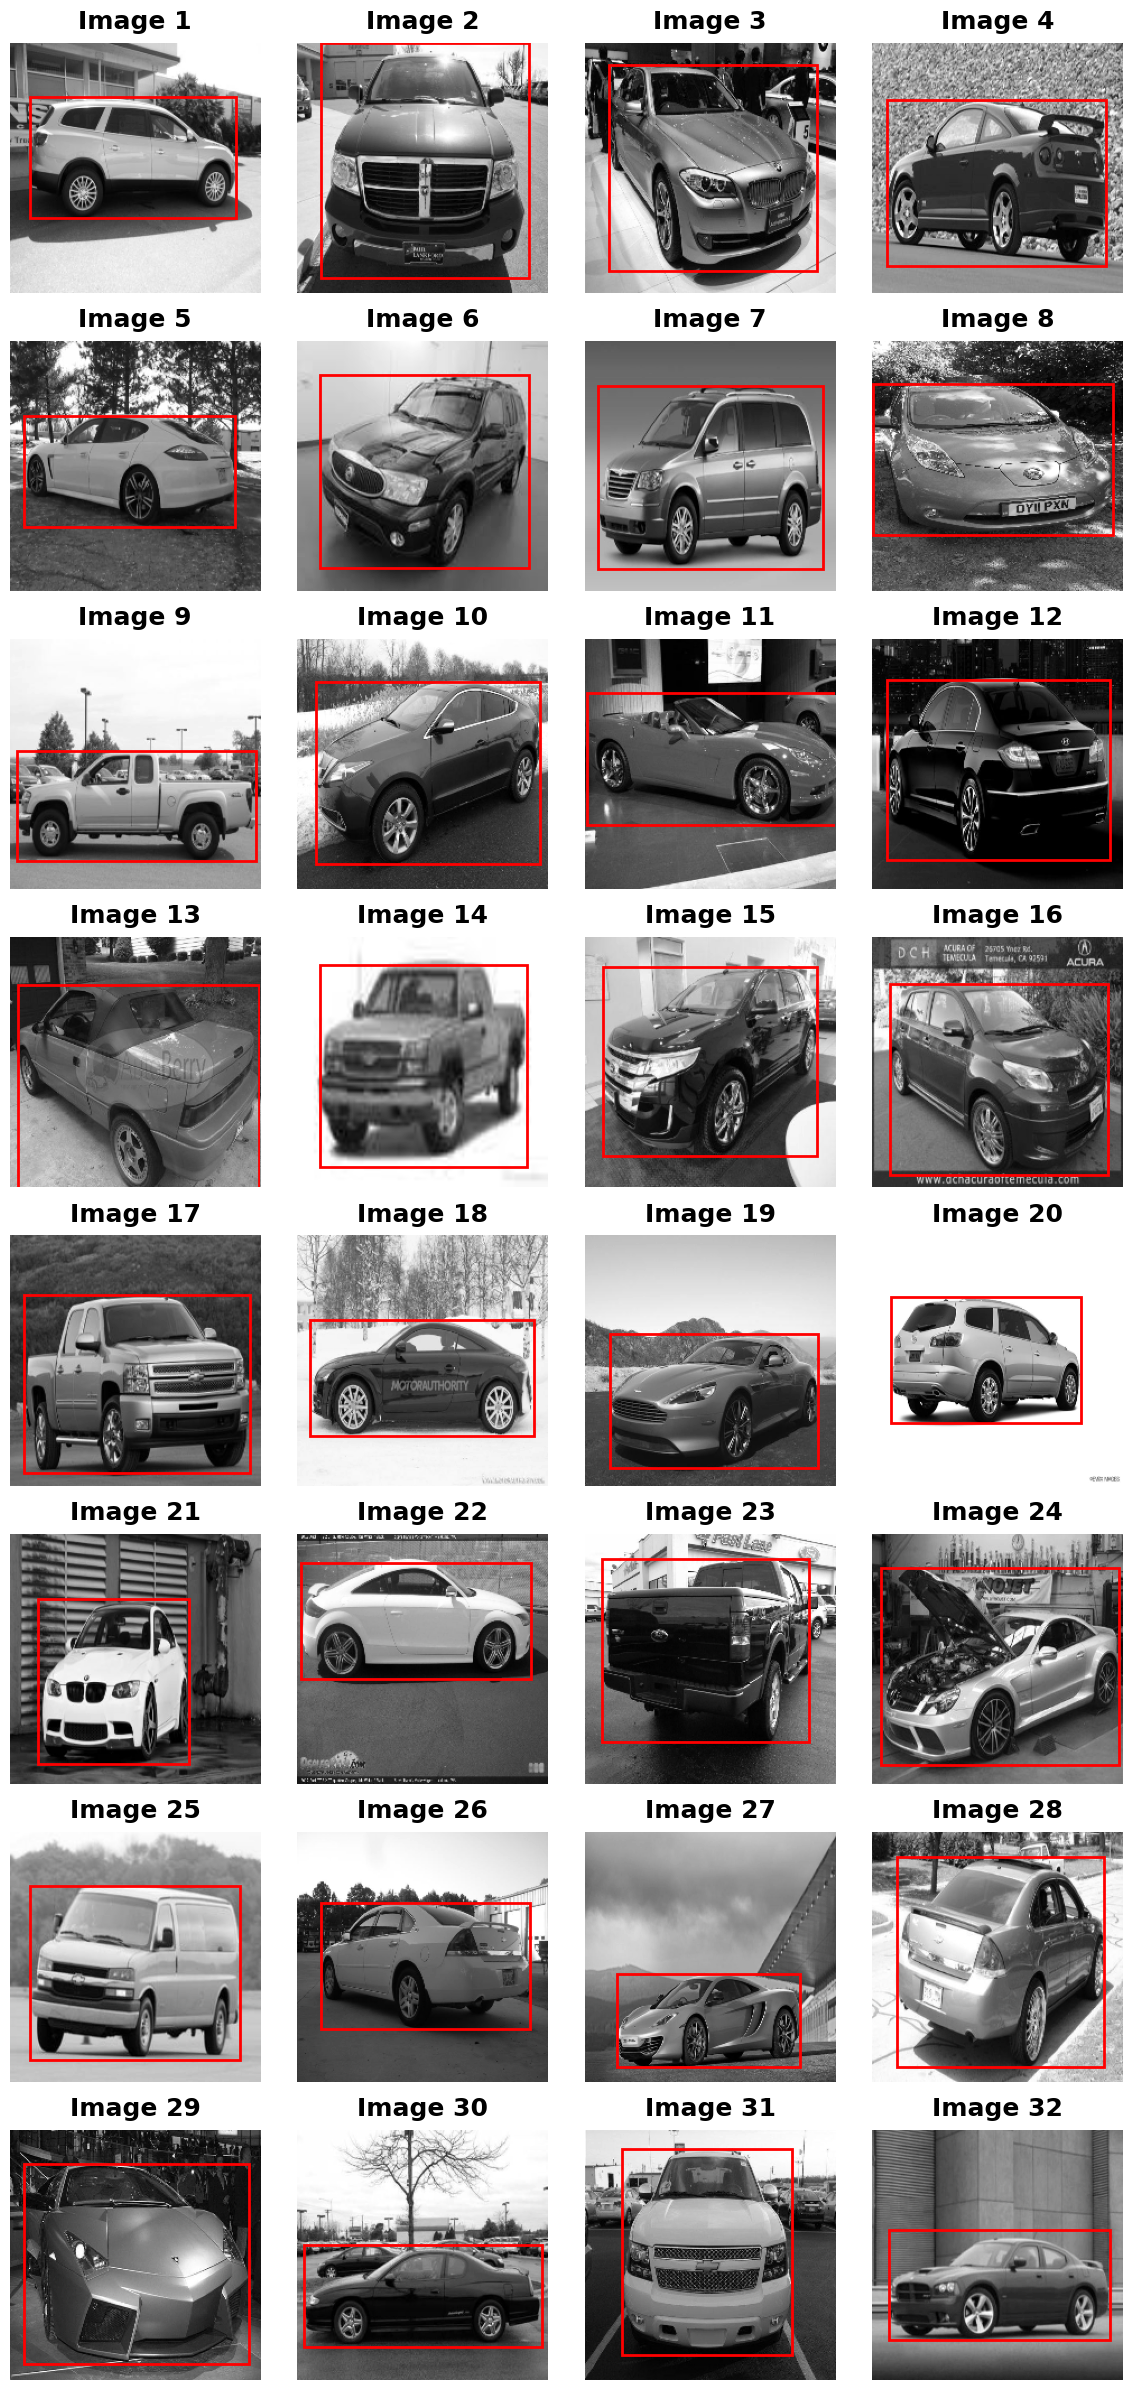

In [8]:

for batch_images, batch_labels in train_ds.take(1):
    visualize_batch(batch_images, batch_labels, batch_size=batch_size, target_size=target_size)


# Defining Model Architecture

In [9]:
from tensorflow.keras import layers, models
image_shape = (224,224,1)

data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=image_shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D())
# adding dense
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation = "sigmoid"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

model.compile(optimizer='adam',
              loss="mse",
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=10,
                    validation_data=valid_ds)

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 70s 154ms/step - accuracy: 0.7792 - loss: 0.0172 - val_accuracy: 0.8418 - val_loss: 0.0073
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 78s 152ms/step - accuracy: 0.8491 - loss: 0.0063 - val_accuracy: 0.8702 - val_loss: 0.0046
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 84s 158ms/step - accuracy: 0.8501 - loss: 0.0055 - val_accuracy: 0.8665 - val_loss: 0.0044
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.8607 - loss: 0.0049 - val_accuracy: 0.8677 - val_loss: 0.0040
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.8601 - loss: 0.0045 - val_accuracy: 0.8745 - val_loss: 0.0040
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 83s 157ms/step - accuracy: 0.8722 - loss: 0.0041 - val_accuracy: 0.8789 - val_loss: 0.0038
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step - accuracy: 0.8685 - loss: 0.0040 - val_accuracy: 0.8820 - val_loss: 0.0036
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - accuracy: 0.8752 - loss: 0

51/51 - 3s - 52ms/step - accuracy: 0.8850 - loss: 0.0037


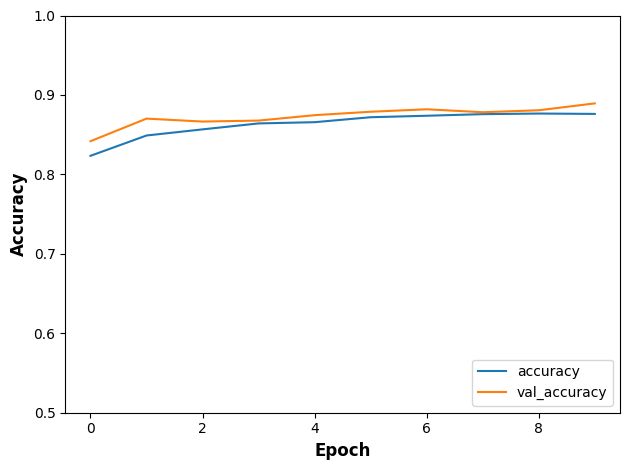

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

# Model Prediction after training

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


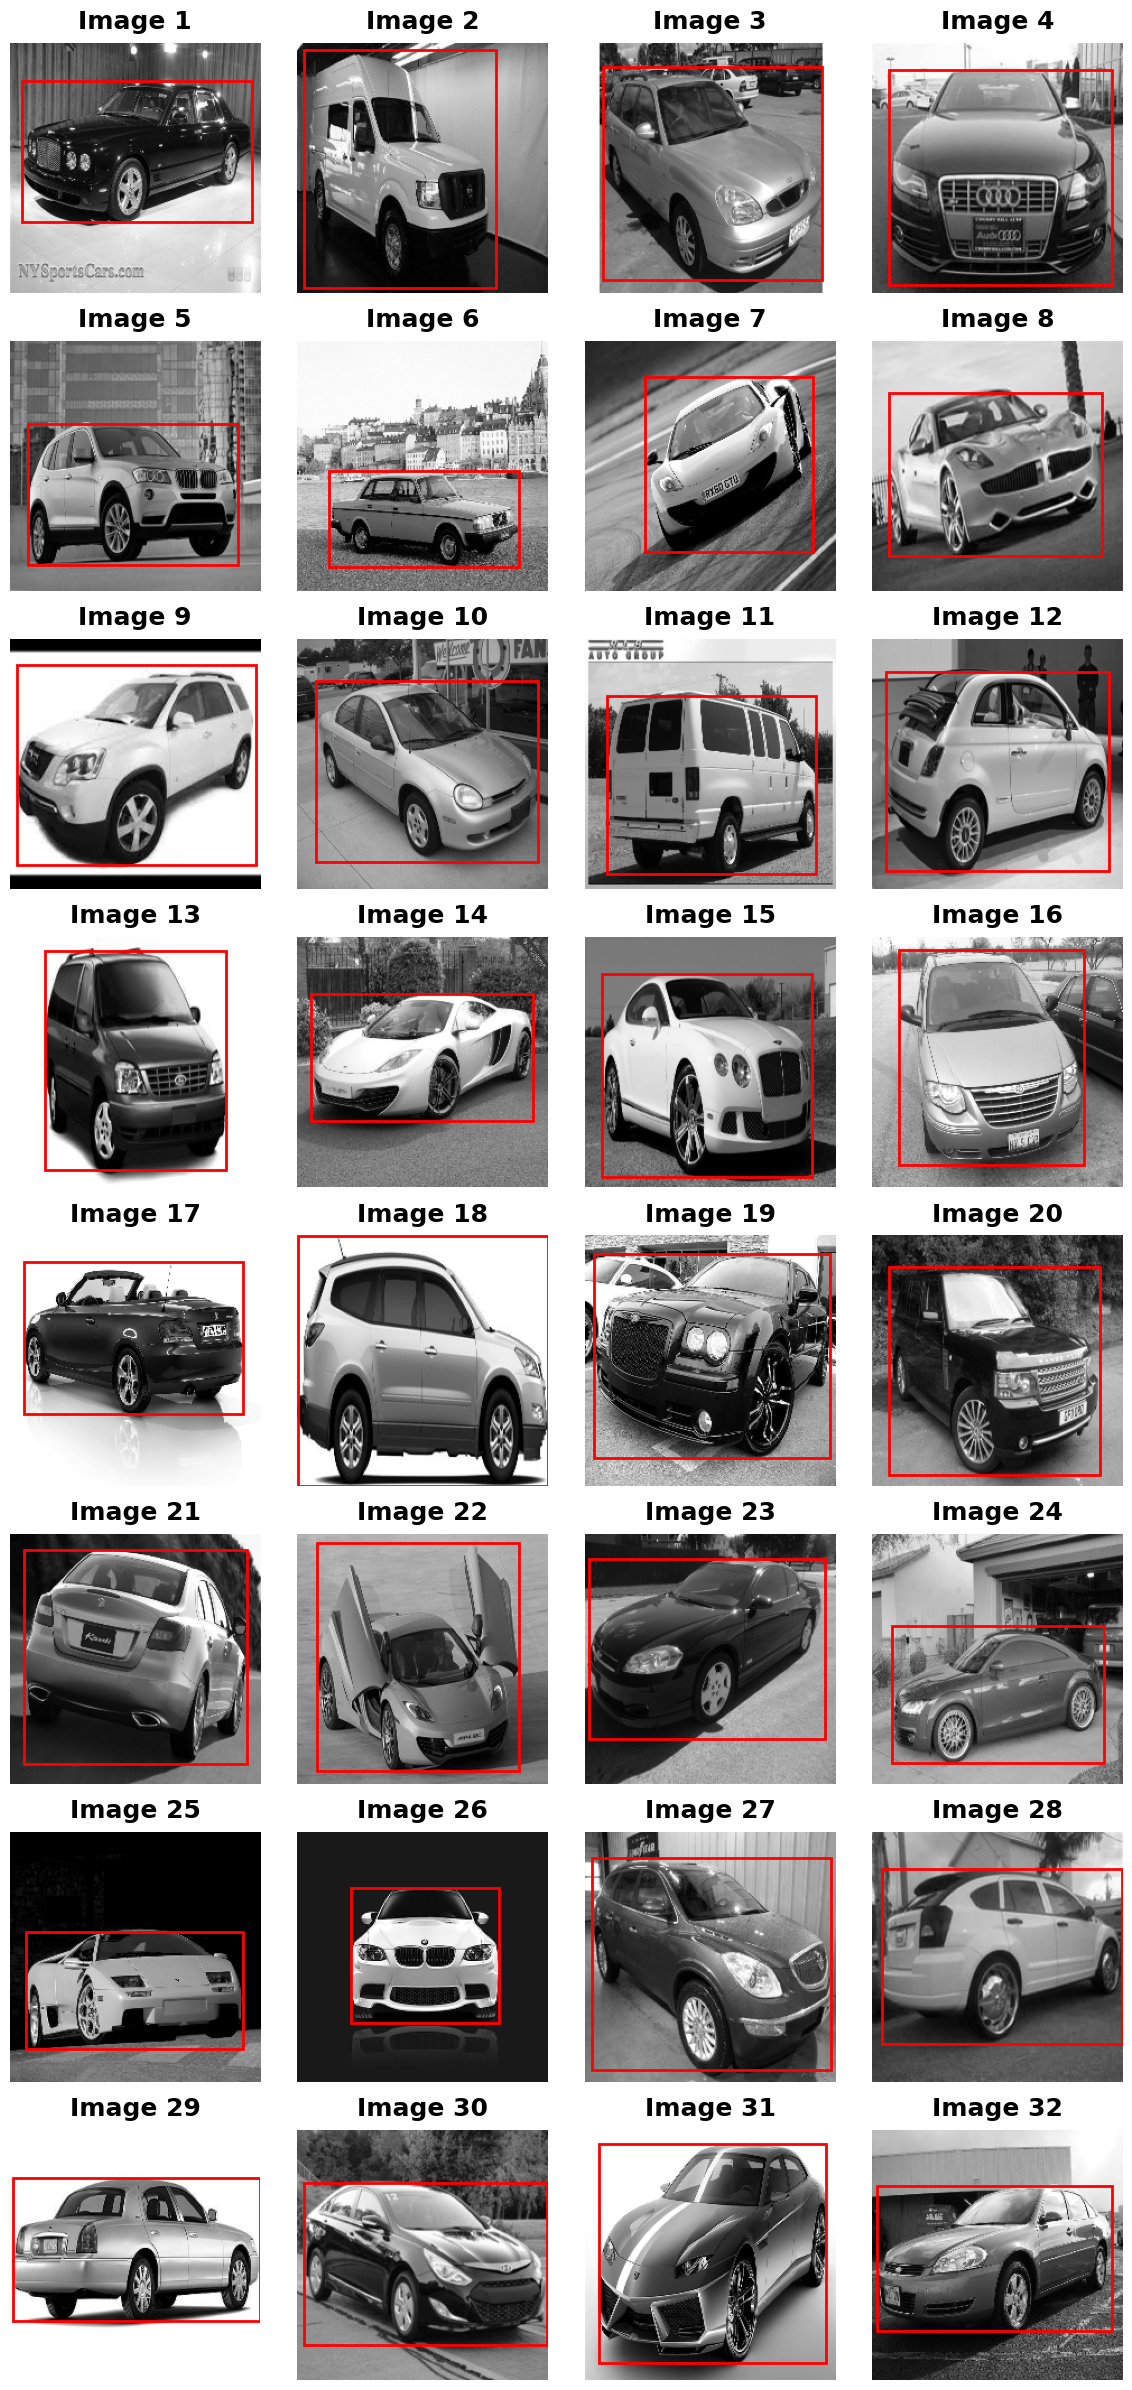

In [12]:
batch_labels = model.predict(test_ds.take(1))
for batch_images, batch_labels in test_ds.take(1):
    visualize_batch(batch_images, batch_labels, batch_size=batch_size, target_size=target_size)